# <u>NSW DCCEEW training &ndash; Demo 6: external data access</u>

 - <b>Author</b>: Eric.Lehmann@csiro.au
 - <b>Release date / version</b>: Aug. 2024, v1.0
 - <b>Dev. platform</b>: CSIRO ADIAS/ADS (hub.adias.aquawatchaus.space)
 - <b>Server profile</b>: EASI Open Data Cube No ML &ndash; Version 2023.10.2 
 - <b>Server resources</b>: 32 CPU &ndash; 64GB RAM
 - <b>Python kernel</b>: `Python 3 (ipykernel)`
 - <b>Dask</b>: Local cluster
  
# Overview

Demonstrates how to access datasets that are 'external' to the current EASI deployment, e.g. from IMOS, other EASI deployments, DEA, BoM, etc.

# User parameters

In [1]:
# Set a bounding box [xmin, ymin, xmax, ymax] in latitude and longitude
min_lat, max_lat = (-34.6919, -33.2479)   # Sydney coastal
min_lon, max_lon = (150.7159, 152.0508)
buf = 1.0

In [2]:
# selected year -- for NRT product
selected_year = 2024

n_workers = None    # for local Dask cluster
# n_workers = 12; workers_mem = 8    # for Dask Gateway cluster

In [3]:
min_lat = min_lat - buf
max_lat = max_lat + buf
min_lon = min_lon - buf
max_lon = max_lon + buf

# Notebook setup

In [4]:
import os, sys, io
import numpy as np
import xarray as xr
from siphon.catalog import TDSCatalog
from IPython.core.display import HTML
# import cmocean.cm as cmo

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from dask.distributed import wait   # , progress

import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

# from: https://github.com/csiro-easi/easi-notebooks.git
sys.path.append('/home/jovyan/git_hub_notebooks/scripts/')
import notebook_utils   # for xarray_object_size(), localcluster_dashboard()
from app_utils import display_map

# Eric's own function for getting coastline data:
exec(open("./get_coastline.py").read())

In [5]:
import warnings

### Filter out following warnings:
# /env/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 32.04 MiB.
# This may cause some slowdown. Consider scattering data ahead of time and using futures.
warnings.filterwarnings("ignore", category=UserWarning)

# warnings.resetwarnings()

In [6]:
### Misc.
cmp = mcolors.LinearSegmentedColormap.from_list("cmp", ["gainsboro", "gainsboro"])   # "dummy" colormap for greyed out land pixels

# Function to create truncated colormap
def truncate_colormap(cmap, minval=0.25, maxval=0.75, n=100):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        'truncated_' + cmap.name, cmap(np.linspace(minval, maxval, n)))
    return new_cmap

jett = truncate_colormap(plt.cm.jet)   # truncated 'jet' colormap

In [7]:
### Local Dask cluster
if n_workers is None:  # local Dask cluster using all available CPUs
    
    from dask.distributed import Client, LocalCluster
    # sys.path.append('/home/jovyan/git_hub_notebooks/scripts/')
    # import notebook_utils   # for localcluster_dashboard()

    cluster = LocalCluster()
    client = Client(cluster)

    print(f"Local cluster dashboard: {notebook_utils.localcluster_dashboard(client,server='https://hub.adias.aquawatchaus.space')}")
    display(cluster)

### Use the following to shut down this cluster:
# cluster.close()
# client.shutdown()

INFO:distributed.scheduler:State start
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-scratch-space/scheduler-yj418aja', purging
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:34533
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36505'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:39025'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:39225'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:32983'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45325'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42869'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33213'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:34415'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:

Local cluster dashboard: https://hub.adias.aquawatchaus.space/user/eric.lehmann/proxy/8787/status


LocalCluster(66d57bc4, 'tcp://127.0.0.1:34533', workers=8, threads=32, memory=64.00 GiB)

In [8]:
### Dask Gateway cluster @ n_workers
if n_workers is not None:

    from dask_gateway import Gateway
    gateway = Gateway()
    
    # shutdown_all_clusters...
    clusterRpts = gateway.list_clusters()
    if len(clusterRpts)>0: print(f"Shutting down running clusters:\n {clusterRpts}")
    for cluster in clusterRpts:
        c = gateway.connect(cluster.name)
        c.shutdown()

    print("Creating new Gateway cluster...")

    options = gateway.cluster_options()
    options.node_selection = "worker" 
    options.worker_cores = 8
    options.worker_memory = workers_mem

    cluster = gateway.new_cluster(cluster_options=options)
    cluster.scale(n_workers)
    display( cluster )

    ### Wait for all workers to start
    client = cluster.get_client()
    display( client )
    client.sync( client._wait_for_workers, n_workers=n_workers )

### Use the following to shut down this cluster:
# cluster.shutdown()
# client.close()

In [9]:
display_map(x=(min_lon,max_lon), y=(min_lat,max_lat))

# Access IMOS Global Sea Level data via thredds service

Demonstrates how to access and load the IMOS - OceanCurrent - Gridded sea level anomaly (GSLA) dataset: https://oceancurrent.aodn.org.au/product.php or https://portal.aodn.org.au/search > Physical Water > Current, or [here](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/0c9eb39c-9cbe-4c6a-8a10-5867087e703a)

Thredds catalog for this product (NRT, available to 2011 &ndash; 2024; vs. DM, delayed mode, 1993 &ndash; 2020 only): https://thredds.aodn.org.au/thredds/catalog/IMOS/OceanCurrent/GSLA/NRT/catalog.html. Here only using a few dates in a given / selected year for illustration purposes.

This is a daily dataset, seemingly with 0.2 x 0.2 deg resolution. Example of how to access this data [here](https://github.com/aodn/imos-user-code-library/blob/master/Python/notebooks/SAR_winds/SAR_winds_getting_started_jupyter_notebook/ausar_winds_getting_started_notebook.ipynb).

The code below accesses the IMOS data via the thredds service though other potential ways of accessing this data could be used, including from an S3 bucket of IMOS data.

In [10]:
cat_url = f"https://thredds.aodn.org.au/thredds/catalog/IMOS/OceanCurrent/GSLA/NRT/{selected_year}/catalog.xml"
cat = TDSCatalog(cat_url)   # connect to the Thredds database

In [11]:
### Show the first few datasets / dates:
cat.datasets[:10]

[IMOS_OceanCurrent_HV_20240101T000000Z_GSLA_FV02_NRT.nc,
 IMOS_OceanCurrent_HV_20240102T000000Z_GSLA_FV02_NRT.nc,
 IMOS_OceanCurrent_HV_20240103T000000Z_GSLA_FV02_NRT.nc,
 IMOS_OceanCurrent_HV_20240104T000000Z_GSLA_FV02_NRT.nc,
 IMOS_OceanCurrent_HV_20240105T000000Z_GSLA_FV02_NRT.nc,
 IMOS_OceanCurrent_HV_20240106T000000Z_GSLA_FV02_NRT.nc,
 IMOS_OceanCurrent_HV_20240107T000000Z_GSLA_FV02_NRT.nc,
 IMOS_OceanCurrent_HV_20240108T000000Z_GSLA_FV02_NRT.nc,
 IMOS_OceanCurrent_HV_20240109T000000Z_GSLA_FV02_NRT.nc,
 IMOS_OceanCurrent_HV_20240110T000000Z_GSLA_FV02_NRT.nc]

In [12]:
%%time

num_dsets = 20   # number of datasets / dates to download (for illustration purposes)

# This executes the data download SERIALLY! (FOR-loop) I.e. the data is downloaded in the workers' memory but
# each date is downloaded one after the other (not in parallel)
dsets = []
for cds in cat.datasets[:num_dsets]:
    tmp = cds.remote_access(use_xarray=True)   # Open the remote dataset and get a netCDF4-compatible `Dataset` object providing index-based subsetting capabilities
    dsets.append( tmp.drop_vars(['start_time','end_time','UCUR','VCUR','UCUR_MEAN','VCUR_MEAN'])
                     .sel(LONGITUDE=slice(min_lon,max_lon), LATITUDE=slice(min_lat,max_lat))
                     .chunk('auto').persist() )
dsets[0]

CPU times: user 3.85 s, sys: 333 ms, total: 4.19 s
Wall time: 26.5 s


<xarray.Dataset>
Dimensions:    (TIME: 1, LONGITUDE: 17, LATITUDE: 17)
Coordinates:
  * TIME       (TIME) datetime64[ns] 2024-01-01
  * LONGITUDE  (LONGITUDE) float64 149.8 150.0 150.2 150.4 ... 152.6 152.8 153.0
  * LATITUDE   (LATITUDE) float64 -35.6 -35.4 -35.2 -35.0 ... -32.8 -32.6 -32.4
Data variables:
    GSLA       (TIME, LATITUDE, LONGITUDE) float32 dask.array<chunksize=(1, 17, 17), meta=np.ndarray>
    GSL        (TIME, LATITUDE, LONGITUDE) float32 dask.array<chunksize=(1, 17, 17), meta=np.ndarray>
Attributes: (12/36)
    abstract:                        Gridded (adjusted) sea level anomaly (GS...
    acknowledgement:                 Any users of IMOS data are required to c...
    author:                          Pilo, Gabriela S
    author_email:                    gabriela.semolinipilo@csiro.au
    citation:                        The citation in a list of references is:...
    Conventions:                     CF-1.6,IMOS-1.4
    ...                              ...
    references:                      http://imos.aodn.org.au/oceancurrent
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    time_coverage_start:             2023-12-19T08:46:02Z
    time_coverage_end:               2024-01-04T23:59:50Z
    title:                           Gridded Sea Level Anomaly - Australia Re...
    DODS_EXTRA.Unlimited_Dimension:  TIME

In [13]:
display(dsets[0].GSLA.attrs['standard_name'])
dsets[0].GSLA.attrs['description']

'sea_surface_height_above_mean_sea_level'

'Altimeter and tidegauge estimates of adjusted sea level anomaly mapped onto a grid using optimal interpolation (OI). For details of  the temporal and spatial covariance functions of the OI see the Reference. The anomaly field is mapped because the geoid is not known to sufficient precision, obliging us to remove the time-mean from all sea level observations. Sea level minus the tides and inverse barometer (IB) response, rather than total sea level, is mapped because it is the quantity from which geostrophic velocities can be estimated, and because total sea level has too much high-frequency energy to be mapped from altimeter data anyway.  To de-alias the altimeter data, we have subtracted the estimates provided by the space agencies of the various high frequency signals, evaluated at the sub-satellite point, as well as applying all the recommended corrections. The altimeters are individually edited for outliers, filtered along-track (see Reference for details) and de-biased by ensurin

In [14]:
display(dsets[0].GSL.attrs['standard_name'])
dsets[0].GSL.attrs['description']

'sea_surface_height_above_geoid'

'GSLA + OFAM3 mean dynamic height'

In [15]:
# Concatenate all dates into single object
ds_subs = xr.concat(dsets, dim='TIME').sortby('TIME').persist()
display(ds_subs)

<xarray.Dataset>
Dimensions:    (TIME: 20, LONGITUDE: 17, LATITUDE: 17)
Coordinates:
  * TIME       (TIME) datetime64[ns] 2024-01-01 2024-01-02 ... 2024-01-18
  * LONGITUDE  (LONGITUDE) float64 149.8 150.0 150.2 150.4 ... 152.6 152.8 153.0
  * LATITUDE   (LATITUDE) float64 -35.6 -35.4 -35.2 -35.0 ... -32.8 -32.6 -32.4
Data variables:
    GSLA       (TIME, LATITUDE, LONGITUDE) float32 dask.array<chunksize=(1, 17, 17), meta=np.ndarray>
    GSL        (TIME, LATITUDE, LONGITUDE) float32 dask.array<chunksize=(1, 17, 17), meta=np.ndarray>
Attributes: (12/36)
    abstract:                        Gridded (adjusted) sea level anomaly (GS...
    acknowledgement:                 Any users of IMOS data are required to c...
    author:                          Pilo, Gabriela S
    author_email:                    gabriela.semolinipilo@csiro.au
    citation:                        The citation in a list of references is:...
    Conventions:                     CF-1.6,IMOS-1.4
    ...                              ...
    references:                      http://imos.aodn.org.au/oceancurrent
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    time_coverage_start:             2023-12-19T08:46:02Z
    time_coverage_end:               2024-01-04T23:59:50Z
    title:                           Gridded Sea Level Anomaly - Australia Re...
    DODS_EXTRA.Unlimited_Dimension:  TIME

In [16]:
### Generate coastline and land mask for current dataset
land_mask, shp_poly = get_coastline( ds_lon_vec=ds_subs.LONGITUDE.values.copy(),
                                     ds_lat_vec=ds_subs.LATITUDE.values.copy(), buf=0.2 ) #, verbose=True )

## Time index issue

There appears to be multiple repeats of some dates along the time series... 

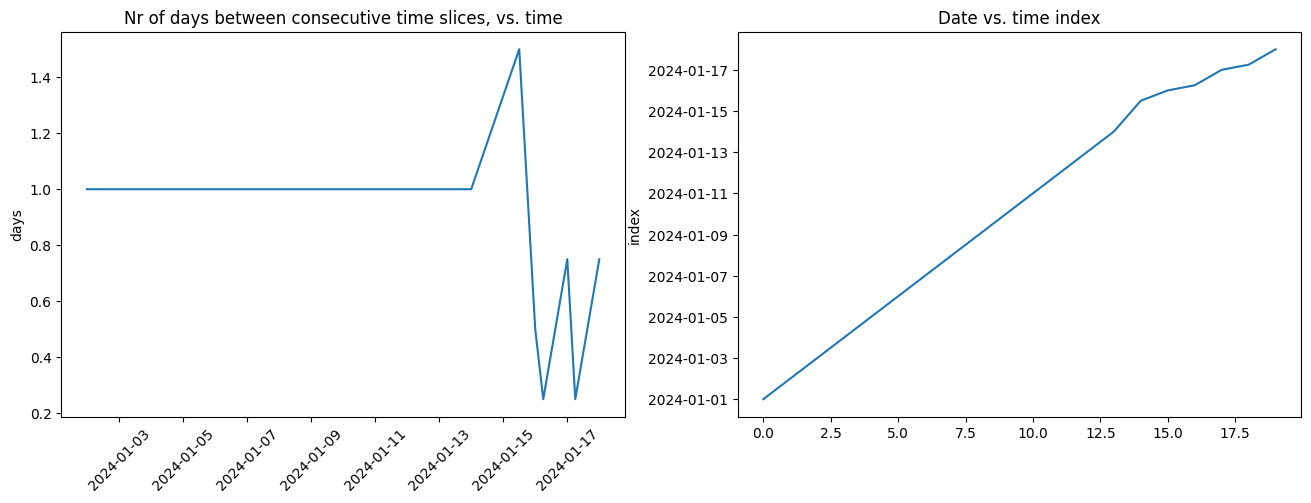

In [17]:
diffvec = np.diff( ds_subs.TIME ) / np.timedelta64(1, 'D')

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,5))

ax1.tick_params(axis='x', rotation=45)
ax1.plot( ds_subs.TIME[1:], diffvec )
ax1.set_ylabel('days'); ax1.set_title('Nr of days between consecutive time slices, vs. time')

ax2.plot(ds_subs.TIME)
ax2.set_ylabel('index'); ax2.set_title('Date vs. time index');

We need to ensure that the dataset has only one time slice per day, so let's group the time slices by days and then combine the multiple-day data using `mean`.

In [18]:
ds_subs = ds_subs.resample(TIME='1D').mean('TIME').persist()
display(ds_subs)
_ = wait(ds_subs)

<xarray.Dataset>
Dimensions:    (LONGITUDE: 17, LATITUDE: 17, TIME: 18)
Coordinates:
  * LONGITUDE  (LONGITUDE) float64 149.8 150.0 150.2 150.4 ... 152.6 152.8 153.0
  * LATITUDE   (LATITUDE) float64 -35.6 -35.4 -35.2 -35.0 ... -32.8 -32.6 -32.4
  * TIME       (TIME) datetime64[ns] 2024-01-01 2024-01-02 ... 2024-01-18
Data variables:
    GSLA       (TIME, LATITUDE, LONGITUDE) float32 dask.array<chunksize=(1, 17, 17), meta=np.ndarray>
    GSL        (TIME, LATITUDE, LONGITUDE) float32 dask.array<chunksize=(1, 17, 17), meta=np.ndarray>
Attributes: (12/36)
    abstract:                        Gridded (adjusted) sea level anomaly (GS...
    acknowledgement:                 Any users of IMOS data are required to c...
    author:                          Pilo, Gabriela S
    author_email:                    gabriela.semolinipilo@csiro.au
    citation:                        The citation in a list of references is:...
    Conventions:                     CF-1.6,IMOS-1.4
    ...                              ...
    references:                      http://imos.aodn.org.au/oceancurrent
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    time_coverage_start:             2023-12-19T08:46:02Z
    time_coverage_end:               2024-01-04T23:59:50Z
    title:                           Gridded Sea Level Anomaly - Australia Re...
    DODS_EXTRA.Unlimited_Dimension:  TIME

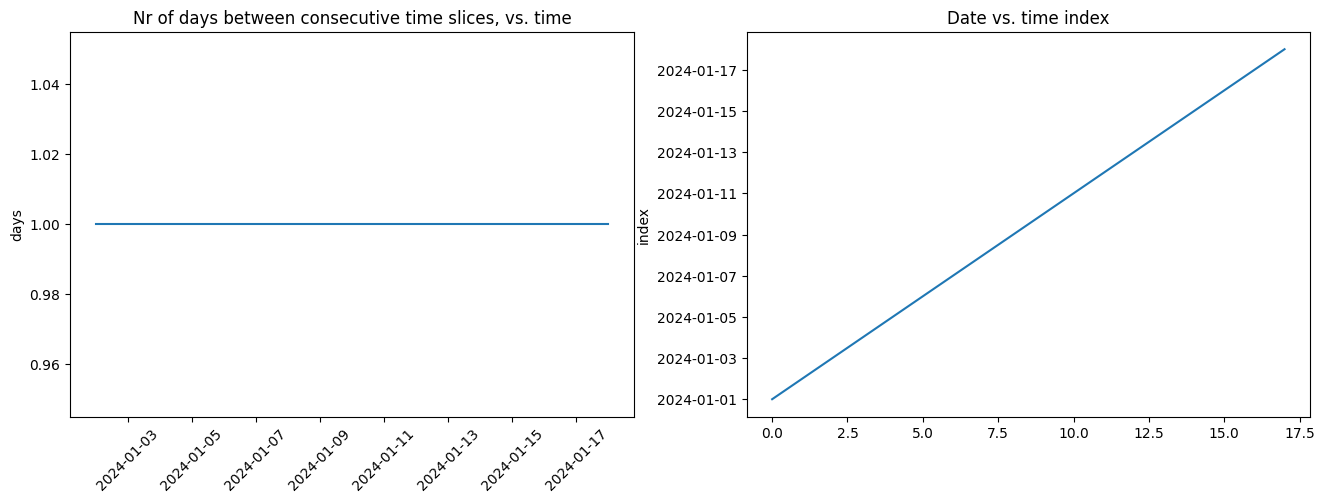

In [19]:
diffvec = np.diff( ds_subs.TIME ) / np.timedelta64(1, 'D')

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,5))

ax1.tick_params(axis='x', rotation=45)
ax1.plot( ds_subs.TIME[1:], diffvec )
ax1.set_ylabel('days'); ax1.set_title('Nr of days between consecutive time slices, vs. time')

ax2.plot(ds_subs.TIME)
ax2.set_ylabel('index'); ax2.set_title('Date vs. time index');

## Demo plots for selected year

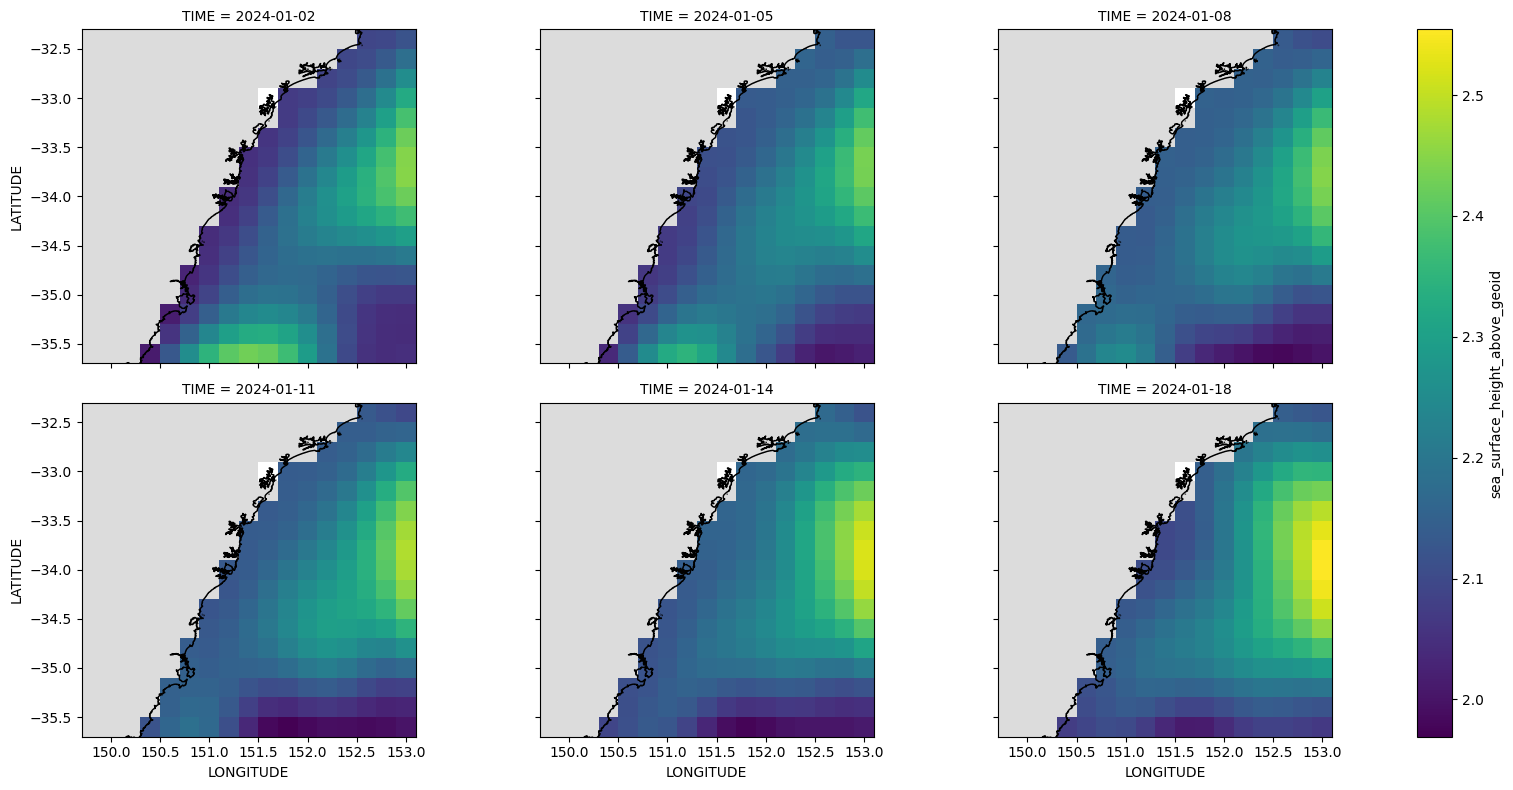

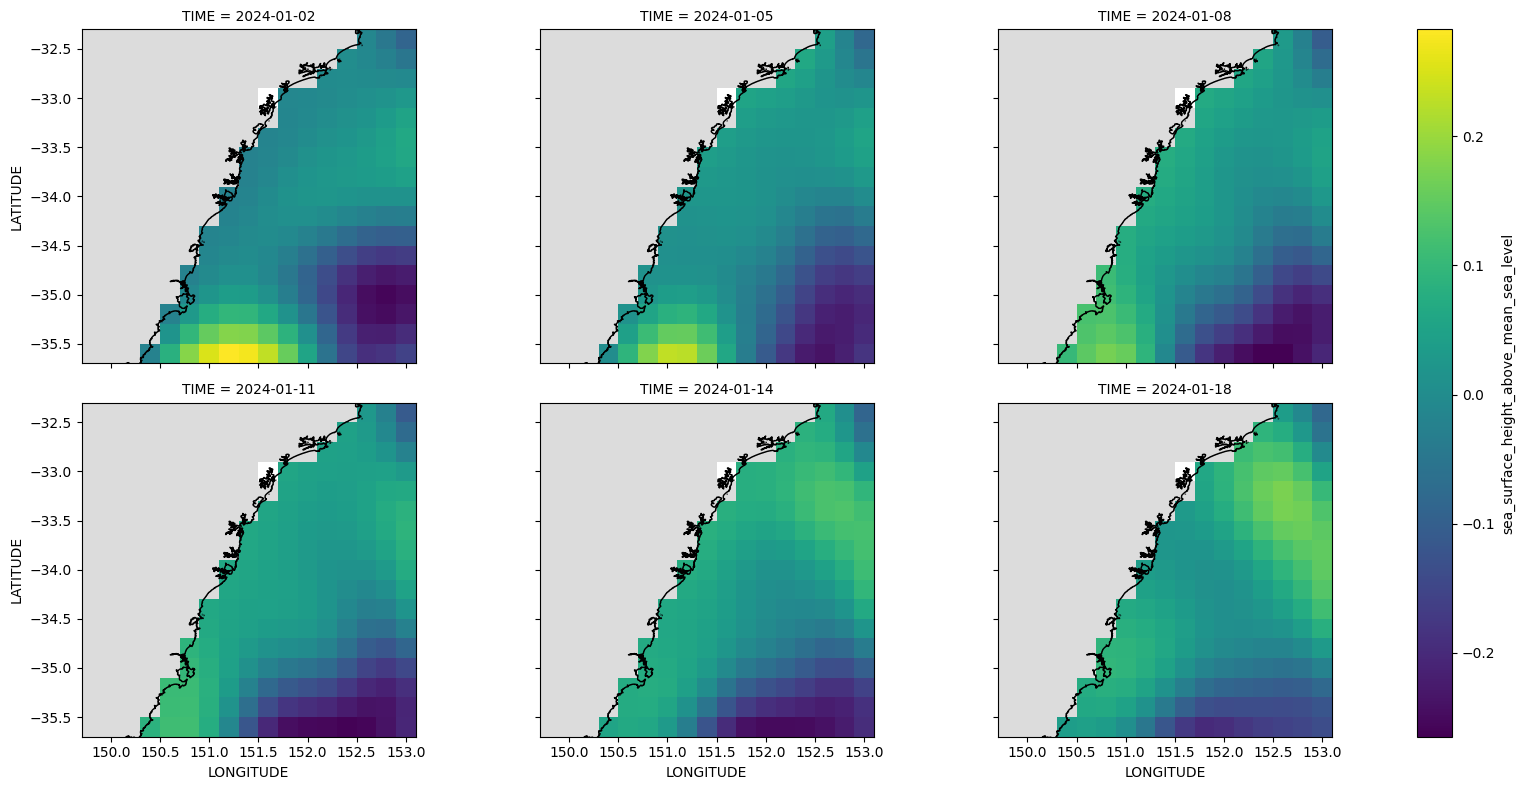

In [20]:
### GSL plots
display(HTML('<h3>Sea level plots'))
plt_ind = np.linspace(2, ds_subs.sizes['TIME'], 6, dtype='int') - 1   # some selected time slices to display
pp = ds_subs.GSL[plt_ind,:,:].plot( col='TIME', col_wrap=3, figsize=(18,8), 
                                    cbar_kwargs={'label': ds_subs.GSL.attrs['standard_name']} )
for ii,ax in enumerate(pp.axs.flat):
    ax.set_aspect('equal','box')
    land_mask.plot(ax=ax, add_colorbar=False, add_labels=False, cmap=cmp)
    shp_poly.boundary.plot(ax=ax, color='black', linewidth=1);
plt.show()

### GSLA plots
display(HTML('<h3>Sea level anomaly plots'))
plt_ind = np.linspace(2, ds_subs.sizes['TIME'], 6, dtype='int') - 1   # some selected time slices to display
pp = ds_subs.GSLA[plt_ind,:,:].plot( col='TIME', col_wrap=3, figsize=(18,8), center=False,
                                     cbar_kwargs={'label': ds_subs.GSLA.attrs['standard_name']} )
for ii,ax in enumerate(pp.axs.flat):
    ax.set_aspect('equal','box')
    land_mask.plot(ax=ax, add_colorbar=False, add_labels=False, cmap=cmp)
    shp_poly.boundary.plot(ax=ax, color='black', linewidth=1);    

# Access CCMP wind data via http access

## Overview

Demonstrates how to access and load the Cross-Calibrated Multi-Platform (CCMP) Wind Vector Analysis Product v3.1 dataset: https://www.remss.com/measurements/ccmp/ (or https://www.remss.com/measurements/wind/)

HTTP data access for this product [here](https://data.remss.com/ccmp/v03.1/).

This is a <b>4-times-daily</b> dataset (every 6 hours), from Jan. 1993 to Jan. 2024, with 0.25 x 0.25 deg resolution. Here demonstrated for one selected month of one selected year.

Please note the following specific warning from the [Remote Sensing Systems](https://www.remss.com/measurements/ccmp/) website:

> The L4.0 CCMP V3.1 products consist of daily files containing four daily maps (00, 06, 12, and 18Z) of each variable. The files are in netCDF-4 format with CF-1.8 compliant metadata. Note that winds are provided for both ocean and land regions. The winds over land are from ERA5 but were subjected to the same adjustments as the oceanic winds which are unlikely to be correct for land surfaces. <b>Therefore, we do not recommend using winds over land.</b>

Further wind datasets could potentially also be sourced from here: https://www.ospo.noaa.gov/Products/atmosphere/wind.html.

In [21]:
selected_year = '2024'
selected_month = '03'

In [22]:
### Function to recursively crawl through dataset's URL tree

def list_nc_files(url, verbose=False):
    nc_files = []
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        links = soup.find_all('a')
        for link in links:
            href = link.get('href')
            if 'To Parent Directory' in link.contents[0]:
                pass
            elif href.endswith('.nc') and 'monthly_mean' not in href:
                tmp = urljoin(url, href)
                if verbose: print(tmp)
                nc_files.append(tmp)
            elif href.endswith('/'):
                tmp = list_nc_files(urljoin(url, href))
                [nc_files.append(ii) for ii in tmp]   # unlist elements of subdirectory
                
    return nc_files

In [23]:
### URL of desired product:
url = f"https://data.remss.com/ccmp/v03.1/Y{selected_year}/M{selected_month}/"

In [24]:
nc_files = list_nc_files(url, verbose=False)

print(f'Total of {len(nc_files)} .nc files...')
nc_files[:10]   # some selected files / dates

Total of 31 .nc files...


['https://data.remss.com/ccmp/v03.1/Y2024/M03/CCMP_Wind_Analysis_20240301_V03.1_L4.nc',
 'https://data.remss.com/ccmp/v03.1/Y2024/M03/CCMP_Wind_Analysis_20240302_V03.1_L4.nc',
 'https://data.remss.com/ccmp/v03.1/Y2024/M03/CCMP_Wind_Analysis_20240303_V03.1_L4.nc',
 'https://data.remss.com/ccmp/v03.1/Y2024/M03/CCMP_Wind_Analysis_20240304_V03.1_L4.nc',
 'https://data.remss.com/ccmp/v03.1/Y2024/M03/CCMP_Wind_Analysis_20240305_V03.1_L4.nc',
 'https://data.remss.com/ccmp/v03.1/Y2024/M03/CCMP_Wind_Analysis_20240306_V03.1_L4.nc',
 'https://data.remss.com/ccmp/v03.1/Y2024/M03/CCMP_Wind_Analysis_20240307_V03.1_L4.nc',
 'https://data.remss.com/ccmp/v03.1/Y2024/M03/CCMP_Wind_Analysis_20240308_V03.1_L4.nc',
 'https://data.remss.com/ccmp/v03.1/Y2024/M03/CCMP_Wind_Analysis_20240309_V03.1_L4.nc',
 'https://data.remss.com/ccmp/v03.1/Y2024/M03/CCMP_Wind_Analysis_20240310_V03.1_L4.nc']

<xarray.Dataset>
Dimensions:    (time: 4, latitude: 720, longitude: 1440)
Coordinates:
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * time       (time) datetime64[ns] 2024-03-01 ... 2024-03-01T18:00:00
Data variables:
    uwnd       (time, latitude, longitude) float32 ...
    vwnd       (time, latitude, longitude) float32 ...
    ws         (time, latitude, longitude) float32 ...
Attributes: (12/54)
    contact:                       Remote Sensing Systems, support@remss.com
    Conventions:                   CF-1.7 ACDD-1.3
    data_structure:                grid
    title:                         RSS CCMP V3.1 6-hourly surface winds (Leve...
    summary:                       RSS VAM 6-hour analyses using ERA-5 wind r...
    institute_id:                  RSS
    ...                            ...
    time_coverage_end:             2024-03-01T23:59:59Z
    platform:                      Space-based Platforms>Earth Observation Sa...
    instrument:                    Earth Remote Sensing Instruments>Passive R...
    history:                       2024-07-18T13:11:01.575010Z - netCDF gener...
    base_date:                     Y2024 M03 D01
    date_created:                  2024-07-18T13:11:01.575010Z

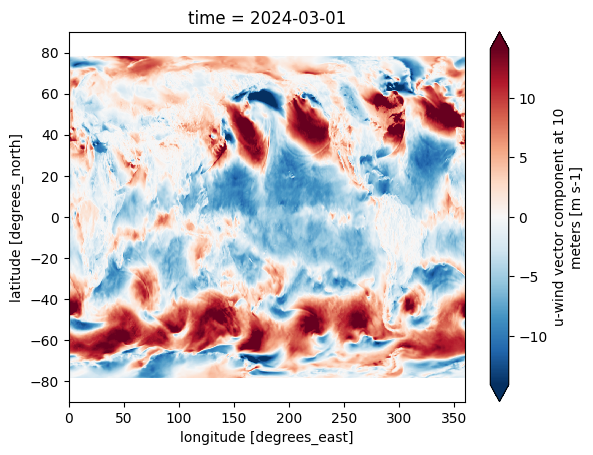

In [25]:
### Investigate one of the datasets
nc_content = requests.get(nc_files[0]).content
ds = xr.open_dataset( io.BytesIO(nc_content), drop_variables='nobs' )   # open the file from memory using xarray
display(ds)
ds.uwnd[0].plot(robust=True);

In [26]:
%%time

# This executes the data download SERIALLY! (FOR-loop)
dsets = []
for ff in nc_files:
    resp = requests.get(ff)
    nc_content = resp.content

    # Open the file from memory using xarray
    ds = xr.open_dataset( io.BytesIO(nc_content), drop_variables='nobs' )
    ds = ds.sel(longitude=slice(min_lon,max_lon), latitude=slice(min_lat,max_lat)).chunk('auto')
    ds = ds.persist()
    dsets.append( ds )

dsets[0]   # shows one time slice example

CPU times: user 23 s, sys: 7.54 s, total: 30.5 s
Wall time: 1min 36s


<xarray.Dataset>
Dimensions:    (time: 4, latitude: 14, longitude: 13)
Coordinates:
  * latitude   (latitude) float32 -35.62 -35.38 -35.12 ... -32.88 -32.62 -32.38
  * longitude  (longitude) float32 149.9 150.1 150.4 150.6 ... 152.4 152.6 152.9
  * time       (time) datetime64[ns] 2024-03-01 ... 2024-03-01T18:00:00
Data variables:
    uwnd       (time, latitude, longitude) float32 dask.array<chunksize=(4, 14, 13), meta=np.ndarray>
    vwnd       (time, latitude, longitude) float32 dask.array<chunksize=(4, 14, 13), meta=np.ndarray>
    ws         (time, latitude, longitude) float32 dask.array<chunksize=(4, 14, 13), meta=np.ndarray>
Attributes: (12/54)
    contact:                       Remote Sensing Systems, support@remss.com
    Conventions:                   CF-1.7 ACDD-1.3
    data_structure:                grid
    title:                         RSS CCMP V3.1 6-hourly surface winds (Leve...
    summary:                       RSS VAM 6-hour analyses using ERA-5 wind r...
    institute_id:                  RSS
    ...                            ...
    time_coverage_end:             2024-03-01T23:59:59Z
    platform:                      Space-based Platforms>Earth Observation Sa...
    instrument:                    Earth Remote Sensing Instruments>Passive R...
    history:                       2024-07-18T13:11:01.575010Z - netCDF gener...
    base_date:                     Y2024 M03 D01
    date_created:                  2024-07-18T13:11:01.575010Z

In [27]:
### Concatenate all dates / datasets
ds_subs = xr.concat(dsets, dim='time').sortby('time').persist()
ds_subs

<xarray.Dataset>
Dimensions:    (time: 124, latitude: 14, longitude: 13)
Coordinates:
  * latitude   (latitude) float32 -35.62 -35.38 -35.12 ... -32.88 -32.62 -32.38
  * longitude  (longitude) float32 149.9 150.1 150.4 150.6 ... 152.4 152.6 152.9
  * time       (time) datetime64[ns] 2024-03-01 ... 2024-03-31T18:00:00
Data variables:
    uwnd       (time, latitude, longitude) float32 dask.array<chunksize=(4, 14, 13), meta=np.ndarray>
    vwnd       (time, latitude, longitude) float32 dask.array<chunksize=(4, 14, 13), meta=np.ndarray>
    ws         (time, latitude, longitude) float32 dask.array<chunksize=(4, 14, 13), meta=np.ndarray>
Attributes: (12/54)
    contact:                       Remote Sensing Systems, support@remss.com
    Conventions:                   CF-1.7 ACDD-1.3
    data_structure:                grid
    title:                         RSS CCMP V3.1 6-hourly surface winds (Leve...
    summary:                       RSS VAM 6-hour analyses using ERA-5 wind r...
    institute_id:                  RSS
    ...                            ...
    time_coverage_end:             2024-03-01T23:59:59Z
    platform:                      Space-based Platforms>Earth Observation Sa...
    instrument:                    Earth Remote Sensing Instruments>Passive R...
    history:                       2024-07-18T13:11:01.575010Z - netCDF gener...
    base_date:                     Y2024 M03 D01
    date_created:                  2024-07-18T13:11:01.575010Z

In [28]:
%%time
### Generate coastline and land mask for current dataset
land_mask, shp_poly = get_coastline( ds_lon_vec=ds_subs.longitude.values.copy(),
                                     ds_lat_vec=ds_subs.latitude.values.copy(), buf=0.2 )  #, verbose=True )

CPU times: user 602 ms, sys: 150 ms, total: 752 ms
Wall time: 704 ms


## Demo plots for selected month and year

In [30]:
latData = ds_subs.latitude[:]
lonData = ds_subs.longitude[:]
TIME = ds_subs.time

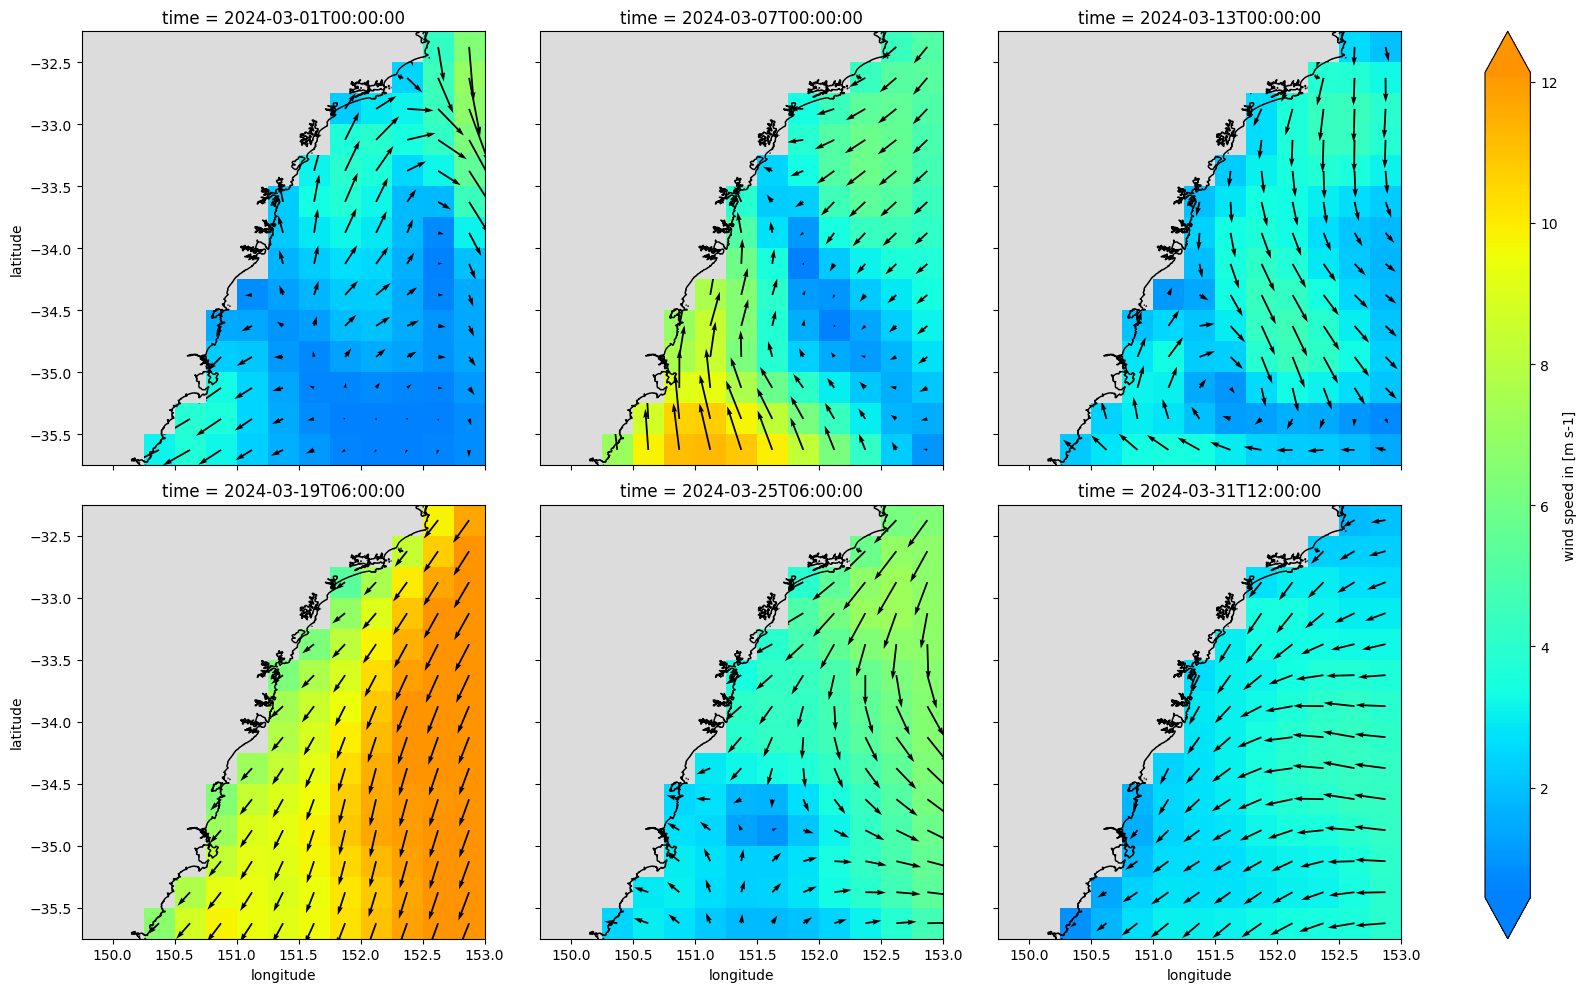

In [31]:
plt_ind = np.linspace(1, ds_subs.sizes['time']-1, 6, dtype='int') - 1   # some selected time slices to display
pp = ds_subs.ws[plt_ind,:,:].plot( col='time', col_wrap=3, robust=True, cmap=jett, figsize=(18,10), 
                                   cbar_kwargs={'label':'wind speed in [' + ds_subs.ws.units + ']'} )

for ii,ax in enumerate(pp.axs.flat):
    ax.set_aspect('equal','box')
    ax.set_title(f"time = {str(TIME[plt_ind[ii]].values).split('.')[0]}")
    ax.quiver(lonData[:], latData[:], ds_subs.uwnd[plt_ind[ii]], ds_subs.vwnd[plt_ind[ii]] )
    land_mask.plot(ax=ax, add_colorbar=False, add_labels=False, cmap=cmp)
    shp_poly.boundary.plot(ax=ax, color='black', linewidth=1);

In [32]:
if n_workers is None:  # local Dask cluster
    cluster.close()
    client.shutdown()
else:   # Gateway cluster
    cluster.shutdown()
    client.close()    

INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:36505'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:39025'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:39225'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:32983'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:45325'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:42869'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0

In [33]:
### End notebook